# Implementing a Neural Network From Scratch with NumPy

## Setup

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from funcs import *
import seaborn as sns
from tqdm import tqdm

## Load Tox21 Dataset

This data is from the Tox21 Data Challenge 2014 -- Nuclear Receptor Signaling Panel **AR Assay** found here:

https://tripod.nih.gov/tox21/challenge/data.jsp#

In [2]:
# Load data
df = pd.read_csv('nr-ar.smiles', sep='\t', header=None).dropna()

# Rename columns
df.columns = ['Smiles', 'ID', 'Active']

# Add fingerprints
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize = 2048)
df['mol'] = df.Smiles.apply(Chem.MolFromSmiles)
df.dropna(inplace = True)
df['fingerprint'] = df.mol.apply(lambda x: np.array(mfpgen.GetFingerprint(x)))

df

[21:58:59] Explicit valence for atom # 0 Cl, 1, is greater than permitted
[21:58:59] Explicit valence for atom # 2 Cl, 1, is greater than permitted
[21:58:59] WARNING: not removing hydrogen atom without neighbors


,Smiles,ID,Active,mol,fingerprint
0,CC(O)=O.CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N...,NCGC00167516-01,0,<rdkit.Chem.rdchem.Mol object at 0x0000020F817...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Cl.CCCCCCOC1=CC=C(C(=N)N(CCCC)CCCC)C2=C1C=CC=C2,NCGC00181091-01,0,<rdkit.Chem.rdchem.Mol object at 0x0000020F817...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,Cl.Cl.COCC(=O)O[C@]3(CCN(C)CCCC1=NC2=C(N1)C=CC...,NCGC00094089-01,0,<rdkit.Chem.rdchem.Mol object at 0x0000020F817...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Cl.Cl.CCCCC(CC)CNC(=N)NC(=N)NCCCCCCNC(=N)NC(=N...,NCGC00094996-01,0,<rdkit.Chem.rdchem.Mol object at 0x0000020F817...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,[Br-].CCCCCCCCCCCC[N+](C)(C)CCOC1=CC=CC=C1,NCGC00257773-01,0,<rdkit.Chem.rdchem.Mol object at 0x0000020F817...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
...,...,...,...,...,...
9357,CCCC1=CC(=O)NC(=S)N1,NCGC00259290-01,0,<rdkit.Chem.rdchem.Mol object at 0x0000020F819...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9358,S=C1NCCN1,NCGC00258846-01,0,<rdkit.Chem.rdchem.Mol object at 0x0000020F819...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9359,S=C1NCCN1,NCGC00254936-01,0,<rdkit.Chem.rdchem.Mol object at 0x0000020F819...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9360,CCOP(=S)(OCC)OC1=CC=C(C=C1)[N+]([O-])=O,NCGC00254571-01,0,<rdkit.Chem.rdchem.Mol object at 0x0000020F819...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Create Train/Test/Val Splits

I am just using a random split in this case. 


80/10/10

In [3]:
#Shuffle dataframe rows
df = df.sample(frac=1, random_state=42).reset_index().drop(columns=['index', 'Smiles', 'mol'])

# Make train/test/val splits
num_samples = len(df)
train_cutoff = int(num_samples*0.8)
test_cutoff = int(num_samples*0.9)
df_train = df[0:train_cutoff]
df_test = df[train_cutoff:test_cutoff]
df_val = df[test_cutoff:]

## Neural Net

In [4]:
df_train

,ID,Active,fingerprint
0,NCGC00254542-01,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,NCGC00093759-01,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,NCGC00183843-01,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,NCGC00258736-01,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,NCGC00256003-01,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
7483,NCGC00016580-01,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7484,NCGC00017043-02,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7485,NCGC00160377-01,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7486,NCGC00255635-01,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\danny\AppData\Local\Temp\ipykernel_32172\3843311853.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['zs'] = df_train.apply(lambda x: weighted_sum(x['fingerprint'], weights, bias), axis=1)
C:\Users\danny\AppData\Local\Temp\ipykernel_32172\3843311853.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['probs'] = sigmoid(zs)
C:\Users\danny\AppData\Local\Temp\ipykernel_32172\3843311853.py:13: SettingWithCopyWarning: 
A value is trying to be

<Axes: >

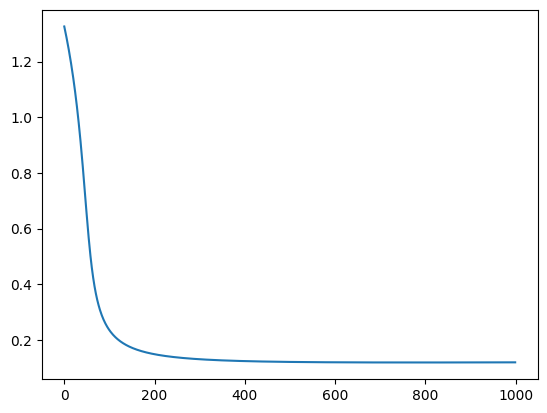

In [55]:
weights = np.random.random(2048)/100
bias = 3

all_losses = []
biases = []

for i in tqdm(range(1000)):
    df_train['zs'] = df_train.apply(lambda x: weighted_sum(x['fingerprint'], weights, bias), axis=1)
    zs = np.array(df_train.zs)

    df_train['probs'] = sigmoid(zs)
    cutoff = 0.5
    df_train['preds'] = df_train.probs.apply(lambda x: 1 if x >= cutoff else 0)
    
    # sns.scatterplot(df_train.probs)
    losses = bce(ground_truths=df_train.Active, predicted_probabilities=df_train.probs)
    dL_weights = np.mean((df_train.probs - df_train.Active)*df_train.probs*(1-df_train.probs)*df_train.fingerprint)

    dL_db = np.mean((df_train.probs - df_train.Active)*(df_train.probs)*(1-df_train.probs))
    learning_rate = 0.1
    weights = weights - learning_rate*dL_weights
    bias = bias - learning_rate*dL_db
    epoch_loss = np.mean(losses)
    all_losses.append(epoch_loss)
    biases.append(bias)

sns.lineplot(all_losses)

<Axes: xlabel='probs', ylabel='Count'>

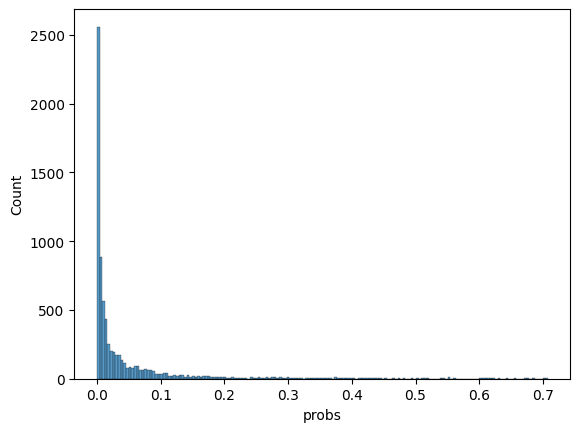

In [56]:
sns.histplot(df_train.probs)

<Axes: >

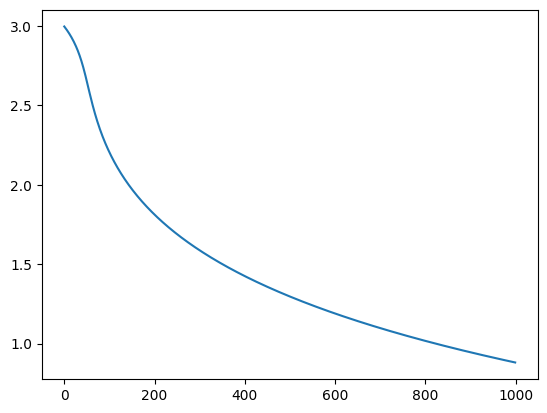

In [57]:
sns.lineplot(biases)

Precision: 0.02247191011235955
Recall: 0.006493506493506494
F1: 0.010075566750629723


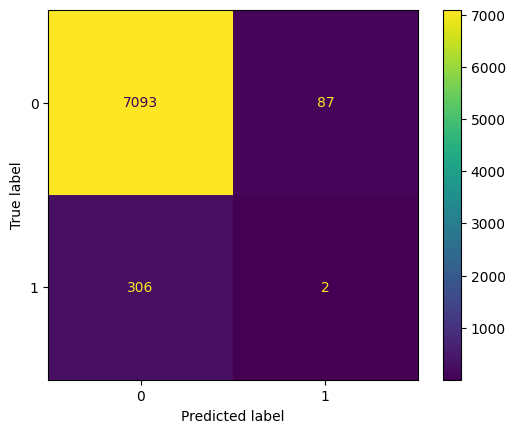

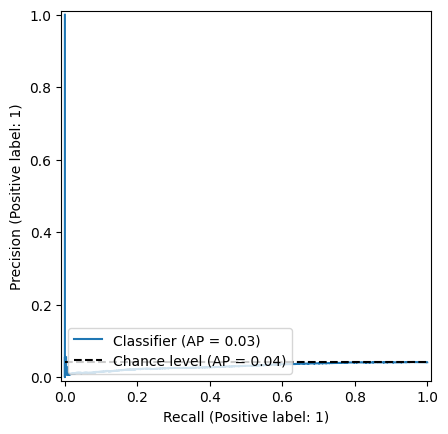

In [59]:
from sklearn import metrics
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, auc, precision_recall_curve

precision, recall, thresholds = metrics.precision_recall_curve(y_true = df_train.Active, y_score=df_train.probs)

ConfusionMatrixDisplay.from_predictions(df_train.Active, df_train.preds)
PrecisionRecallDisplay.from_predictions(df_train.Active, df_train.probs, plot_chance_level=True)
print(f'Precision: {precision_score(df_train.Active, df_train.preds, zero_division=np.nan)}')
print(f'Recall: {recall_score(df_train.Active, df_train.preds, zero_division=np.nan)}')
print(f'F1: {f1_score(df_train.Active, df_train.preds, zero_division=np.nan)}')